<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/customnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Neural Net

In [1]:
from numpy import loadtxt
import numpy as np
import os
import shutil
import math
import zipfile
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Optimizer
from keras import backend as K
import itertools

import sklearn 
from sklearn import metrics
import tensorflow_addons as tfa

# GPU Setup

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Unzip Dataset

In [3]:
dataset_name = 'dataset_binary'
zip_file_path = '/content/' + dataset_name + '.zip'
unzipped_dir = '/content'
dataset_X = '/content/' + dataset_name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

#Create Dataloader

In [79]:
BATCH_SIZE = 32
ORIG_IMG_SIZE = (96, 96)
ORIG_COLOR_MODE ='grayscale'
IMG_SIZE = (96, 96)
COLOR_MODE = 'grayscale'
LABEL_MODE='binary'

train_dataset = image_dataset_from_directory(dataset_X +'/train/', label_mode=LABEL_MODE, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
dev_dataset = image_dataset_from_directory(dataset_X +'/dev/', label_mode=LABEL_MODE, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
test_dataset = image_dataset_from_directory(dataset_X +'/test/', label_mode=LABEL_MODE, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)

Found 33915 files belonging to 2 classes.
Found 5339 files belonging to 2 classes.
Found 2819 files belonging to 2 classes.


In [5]:
def show_example(train_dataset):
  for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = np.asarray(image[0]).squeeze()
    print(first_image.shape)
    plt.gray()
    plt.imshow(first_image / 255, plt.get_cmap('gray'))
    plt.axis('off')
    break 

# Run with this line:
# show_example(train_dataset)

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
dev_dataset = dev_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Fully Connected Model

In [10]:
model_full = keras.Sequential(
    [
        keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 1)),  # 96x96 greyscale image
        layers.Flatten(name='flatten'),
        Dense(64, activation='relu', name='1'),
        Dense(64, activation='relu', name='2'),
        Dense(64, activation='relu', name='3'),
        Dense(64, activation='relu', name='4'),
        Dense(128, activation='relu', name='5'),
        Dense(128, activation='relu', name='6'),
        Dense(128, activation='relu', name='7'),
        Dense(128, activation='relu', name='8'),
        Dense(128, activation='relu', name='9'),
        Dense(64, activation='relu', name='10'),
        Dense(64, activation='relu', name='11'),
        Dense(64, activation='relu', name='12'),
        Dense(64, activation='relu', name='13'),
        Dense(64, activation='relu', name='14'),
        Dense(1, activation='sigmoid', name='15'),
    ]
)

In [31]:
model = model_full
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
1 (Dense)                    (None, 64)                589888    
_________________________________________________________________
2 (Dense)                    (None, 64)                4160      
_________________________________________________________________
3 (Dense)                    (None, 64)                4160      
_________________________________________________________________
4 (Dense)                    (None, 64)                4160      
_________________________________________________________________
5 (Dense)                    (None, 128)               8320      
_________________________________________________________________
6 (Dense)                    (None, 128)               1

# Standard Optimizer

In [7]:
# num_classes = 2

In [12]:
# def f1_score(num_classes):
#   return tfa.metrics.F1Score(num_classes=num_classes, average="weighted")

In [13]:
# Compile model with accuracy and weighted F1 Score
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score(num_classes)])

# Custom Optimizer
Implements model with power of two weights.

In [14]:
# NUMPY TESTING FUNCTIONS

# def closestpow2numpy(num):
#   return np.sign(num)*np.array(np.power(2, np.round(np.log(np.round(np.absolute(num)))/np.log(2))), dtype=int)

# print(closestpow2numpy([0, 1, 2, 3, 4, 6.1, 32, 1.29, 1.5, 0.001]))
# print(closestpow2numpy(-1*np.array([0, 1, 2, 3, 4, 6.1, 32, 1.29, 1.5, 0.001])))


# def intsnumpy(num):
#   return np.round_(np.clip(16*(num - np.mean(num)) / np.sqrt(np.var(num)), -16.,16))

# print(intsnumpy([0, 1, 2, 3, 4, 6.1, 32, 1.29, 1.5, 0.001]))
# print(intsnumpy(-1*np.array([0, 1, 2, 3, 4, 6.1, 32, 1.29, 1.5, 0.001])))

# def closestpow2fixedptnumpy(num):
#   return np.sign(num)*np.array(np.power(2, np.round(np.log(np.absolute(num))/np.log(2))), dtype=float)

# print(closestpow2fixedptnumpy(np.array([0.0012, 0.23, 0.53, 0.38, 0.75, 0.127])))
# print(closestpow2fixedptnumpy(-1*np.array([0.0012, 0.23, 0.53, 0.38, 0.75, 0.127])))


In [15]:
def closestpow2(num):
  return K.cast(K.sign(num)*K.pow(2.0, K.round(K.log(K.abs(num))/K.log(2.0))), dtype='float32')

# def ints(num):
#   return K.round(K.clip(16*(num - K.mean(num)) / K.sqrt(K.var(num)), -16.,16))

In [7]:
class Pow2Update(Optimizer):
  def __init__(self, learning_rate=0.01, name="Pow2Update", **kwargs):
    super(Pow2Update, self).__init__(name, **kwargs)
    self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))

  @tf.function
  def _resource_apply_dense(self, grad, var):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    lr_t = self._decayed_lr(var_dtype)

    var.assign(closestpow2(var - lr_t*grad))

    # ====== Optimizer Graveyard ======
    # var.assign(var - lr_t*grad)
    # var.assign(closestpow2(var - closestpow2(lr_t*grad)))
    # var.assign(K.clip(var - lr_t*grad, -16, 16))
    
    # mean = K.mean(var)
    # stddev = K.sqrt(K.var(var))
    # shifted_var = (var - mean) / stddev
    # var.assign(K.round(K.clip(shifted_var, -16.,16)))
    # =================================
  
  def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

  def get_config(self):
      base_config = super().get_config()
      return {
          **base_config,
          "learning_rate": self._serialize_hyperparameter("learning_rate"),
      }


In [8]:
po = Pow2Update()

po.get_config()

{'learning_rate': 0.01, 'name': 'Pow2Update'}

In [3]:
K.clear_session()
# model.get_weights()

In [26]:
model.compile(loss='binary_crossentropy', optimizer=Pow2Update(learning_rate=0.01), metrics=['accuracy'])

# Initial Model Training

## Initial results without training

In [27]:
loss0, accuracy0 = model.evaluate(dev_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

167/167 [==============================] - 2s 13ms/step - loss: 0.7573 - accuracy: 0.5025
initial loss: 0.76
initial accuracy: 0.50


## Fit (Initial)

In [28]:
initial_epochs = 10

In [29]:
# Configure eary stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [30]:
history = model.fit(train_dataset,
                epochs=initial_epochs,
                validation_data=dev_dataset)
                # callbacks=[callback])

Epoch 1/10
1060/1060 [==============================] - 17s 16ms/step - loss: 0.5347 - accuracy: 0.7334 - val_loss: 0.5563 - val_accuracy: 0.7196
Epoch 2/10
1060/1060 [==============================] - 17s 16ms/step - loss: 0.4928 - accuracy: 0.7675 - val_loss: 0.5185 - val_accuracy: 0.7483
Epoch 3/10
1060/1060 [==============================] - 17s 16ms/step - loss: 0.4947 - accuracy: 0.7651 - val_loss: 0.6257 - val_accuracy: 0.6743
Epoch 4/10
1060/1060 [==============================] - 17s 16ms/step - loss: 0.5205 - accuracy: 0.7605 - val_loss: 0.5585 - val_accuracy: 0.7219
Epoch 5/10
1060/1060 [==============================] - 18s 17ms/step - loss: 0.4969 - accuracy: 0.7745 - val_loss: 0.5576 - val_accuracy: 0.7181
Epoch 6/10
1060/1060 [==============================] - 17s 16ms/step - loss: 0.4912 - accuracy: 0.7776 - val_loss: 0.5368 - val_accuracy: 0.7428
Epoch 7/10
1060/1060 [==============================] - 17s 16ms/step - loss: 0.4814 - accuracy: 0.7837 - val_loss: 0.5284 -

In [32]:
binary = True
if binary:
  model.save('/content/binary_model_1_lr01')

save_to_drive=True
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/binary_model_1_lr01')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/binary_model_1_lr01/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Haptic Vest/binary_model_1_lr01/assets


In [38]:
second_train_epochs=initial_epochs+10

In [39]:
history_cont = model.fit(train_dataset,
                initial_epoch=history.epoch[-1],
                epochs=second_train_epochs,
                validation_data=dev_dataset)

Epoch 10/20
1060/1060 [==============================] - 17s 16ms/step - loss: 0.4769 - accuracy: 0.7853 - val_loss: 0.5503 - val_accuracy: 0.7372
Epoch 11/20
1060/1060 [==============================] - 17s 16ms/step - loss: 0.4744 - accuracy: 0.7890 - val_loss: 0.5343 - val_accuracy: 0.7483
Epoch 12/20
1060/1060 [==============================] - 16s 16ms/step - loss: 0.4737 - accuracy: 0.7896 - val_loss: 0.5392 - val_accuracy: 0.7441
Epoch 13/20
1060/1060 [==============================] - 17s 16ms/step - loss: 0.4714 - accuracy: 0.7899 - val_loss: 0.5331 - val_accuracy: 0.7492
Epoch 14/20
1060/1060 [==============================] - 17s 16ms/step - loss: 0.4696 - accuracy: 0.7900 - val_loss: 0.5347 - val_accuracy: 0.7458
Epoch 15/20
1060/1060 [==============================] - 17s 16ms/step - loss: 0.4681 - accuracy: 0.7910 - val_loss: 0.5334 - val_accuracy: 0.7477
Epoch 16/20
1060/1060 [==============================] - 16s 16ms/step - loss: 0.4694 - accuracy: 0.7920 - val_loss: 0

In [41]:
binary = True
if binary:
  model.save('/content/binary_model_2_lr01')

save_to_drive=True
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/binary_model_2_lr01')

INFO:tensorflow:Assets written to: /content/binary_model_2_lr01/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Haptic Vest/binary_model_2_lr01/assets


# Learning Plots

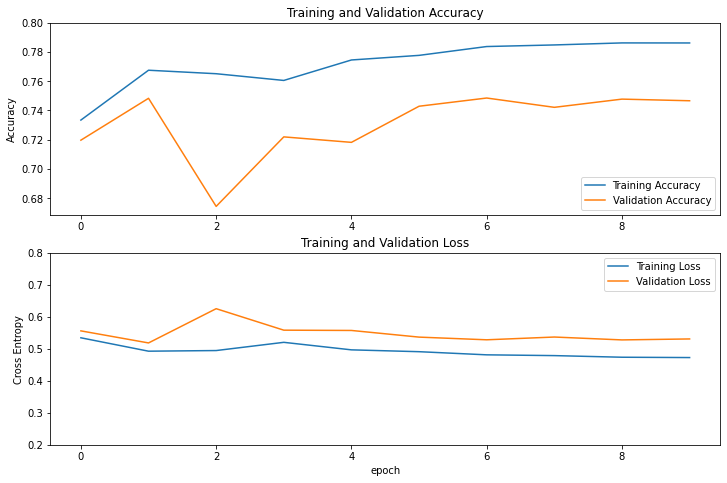

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.8])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.2,.8])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

In [55]:
acc += history_cont.history['accuracy']
val_acc += history_cont.history['val_accuracy']

loss += history_cont.history['loss']
val_loss += history_cont.history['val_loss']

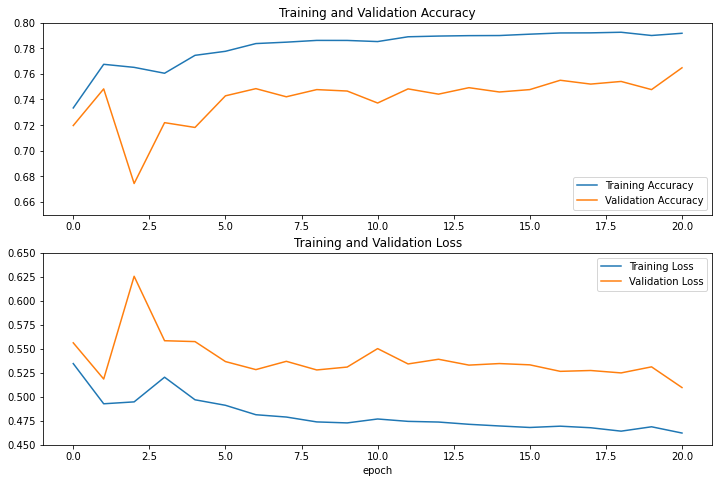

In [67]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.65, 0.8])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.45, 0.65])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

# Model Evaluations

In [10]:
pow2model_path = '/content/drive/MyDrive/Haptic Vest/binary_model_2_lr01'
pow2model = keras.models.load_model(pow2model_path, custom_objects={'Pow2Update':Pow2Update()})

In [11]:
min_param = float('inf')
max_param = 0.0000001
weights = pow2model.get_weights()
for layer in weights:
  min_layer = np.amin(np.absolute(layer))
  max_layer = np.amax(np.absolute(layer))
  if min_layer != 0 and np.log(min_layer)/np.log(2) < np.log(min_param)/np.log(2):
    min_param = min_layer
  if max_layer != 0 and np.log(max_layer)/np.log(2) > np.log(max_param)/np.log(2):
    max_param = max_layer
  
print(min_param, np.log(min_param)/np.log(2))
print(max_param, np.log(max_param)/np.log(2))

2.3841858e-07 -22.00000006045238
0.25 -2.0000000054956706


In [69]:
_, accuracy = pow2model.evaluate(train_dataset)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy = pow2model.evaluate(dev_dataset)
print('Accuracy: %.2f' % (accuracy*100))

# Uncomment after development
_, accuracy = pow2model.evaluate(test_dataset)
print('Accuracy: %.2f' % (accuracy*100))

1060/1060 [==============================] - 14s 13ms/step - loss: 0.4589 - accuracy: 0.7944
Accuracy: 79.44
167/167 [==============================] - 2s 12ms/step - loss: 0.5097 - accuracy: 0.7647
Accuracy: 76.47
89/89 [==============================] - 1s 12ms/step - loss: 0.5075 - accuracy: 0.7659
Accuracy: 76.59


# Incorrect Predictions: Confusion Matrix & Highest Losses

In [76]:
def to_one_hot(class_id_pre):
  return [int(class_id_pre == 1), int(class_id_pre == 3)]

to_one_hot(1)

[1, 0]

In [110]:
incorrect_predictions = []

In [111]:
confusion_matrix = np.zeros((2,2), dtype=int)

class_ids = [1,3]
counter = 0
bad_counter = 0
for class_id in class_ids:
  base_test_path = '/content/dataset_binary/train/' + str(class_id) + '/'
  for entry in os.scandir(base_test_path):
    try:
      test_img = keras.preprocessing.image.load_img(entry.path, target_size=IMG_SIZE)
      img_array = keras.preprocessing.image.img_to_array(test_img)
      img_array = tf.expand_dims(img_array, 0)  # Create batch axis
      img_array = img_array[:,:,:,0]
      predictions = pow2model.predict(img_array)
      score = predictions[0]
      class_pred = 1 if score < 0.5 else 3
      class_id_idx = 0 if class_id == 1 else 1
      class_pred_idx = 0 if class_pred == 1 else 1
      if class_id != class_pred:
        loss = tf.keras.losses.binary_crossentropy(class_id, score)
        incorrect_predictions.append((float(loss), entry.path, class_id, class_pred))
      confusion_matrix[class_id_idx][class_pred_idx] += 1
    except:
      print(f'BAD FILE: {entry.path}')
      bad_counter +=1
      if bad_counter == len(class_ids)+1:  # in case there's a problem, this should break the loop (but ignore the .DS_Store files)
        assert False

    if counter % 1000 == 0:
      print(f"{counter} images processed")
    counter += 1

print(confusion_matrix)

0 images processed
1000 images processed
2000 images processed
3000 images processed
4000 images processed
5000 images processed
6000 images processed
7000 images processed
8000 images processed
9000 images processed
10000 images processed
11000 images processed
12000 images processed
13000 images processed
14000 images processed
15000 images processed
16000 images processed
17000 images processed
18000 images processed
19000 images processed
BAD FILE: /content/dataset_binary/train/1/.DS_Store
20000 images processed
21000 images processed
22000 images processed
23000 images processed
24000 images processed
25000 images processed
26000 images processed
27000 images processed
28000 images processed
29000 images processed
30000 images processed
31000 images processed
32000 images processed
33000 images processed
[[18761  3048]
 [ 3919  8187]]


In [112]:
saved_confusion = confusion_matrix
print(saved_confusion)

[[18761  3048]
 [ 3919  8187]]


Text(0.5, -5.759144981614817, 'Predicted label')

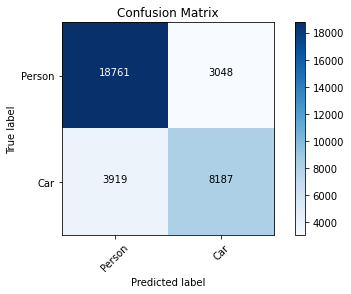

In [113]:
classes = ['Person', 'Car']
cm = saved_confusion
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [117]:
def get_k_worst_preds(k, preds):
  return sorted(preds, key=lambda elem: float(elem[0]), reverse=True)[:k]

def non_car_sorter(elem):
  if elem[2] != 3:
    return float(elem[0])
  return 0

def get_k_worst_non_car_preds(k, preds):
  return sorted(preds, key=non_car_sorter, reverse=True)[:k]

print(get_k_worst_preds(9, incorrect_predictions))
print(get_k_worst_non_car_preds(9, incorrect_predictions))

[(0.6929681301116943, '/content/dataset_binary/train/1/000000482574.jpg', 1, 3), (0.6929430961608887, '/content/dataset_binary/train/1/000000513319.jpg', 1, 3), (0.6929343938827515, '/content/dataset_binary/train/1/000000184207.jpg', 1, 3), (0.6928402781486511, '/content/dataset_binary/train/1/000000217339.jpg', 1, 3), (0.6927334666252136, '/content/dataset_binary/train/1/000000036563.jpg', 1, 3), (0.6927317976951599, '/content/dataset_binary/train/1/000000305156.jpg', 1, 3), (0.6925502419471741, '/content/dataset_binary/train/1/000000346915.jpg', 1, 3), (0.6925237774848938, '/content/dataset_binary/train/1/000000562488.jpg', 1, 3), (0.6924246549606323, '/content/dataset_binary/train/1/000000261902.jpg', 1, 3)]


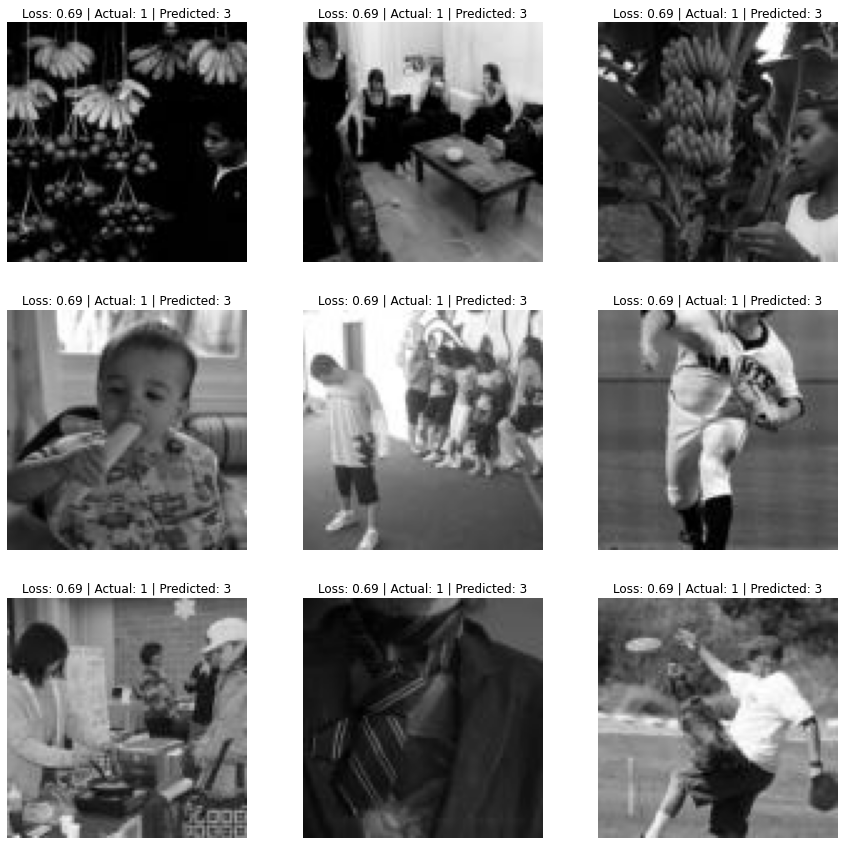

In [119]:
plt.figure(figsize=(15, 15))
num_incorrect_display = 9
display_idx = 0
loss_display_function = get_k_worst_non_car_preds
# loss_display_function = get_k_worst_preds
for loss, incorrect_path, incorrect_actual, incorrect_pred in loss_display_function(num_incorrect_display, incorrect_predictions):
  display_idx += 1
  loss_rounded = np.round_(float(loss),2)
  incorrect_img = keras.preprocessing.image.load_img(incorrect_path, target_size=IMG_SIZE)
  incorrect_img_array = keras.preprocessing.image.img_to_array(incorrect_img)
  ax = plt.subplot(np.sqrt(num_incorrect_display), np.sqrt(num_incorrect_display), display_idx)
  # plt.figure()
  plt.axis("off")
  plt.title(f"Loss: {loss_rounded} | Actual: {incorrect_actual} | Predicted: {incorrect_pred}") #\n{incorrect_path}
  plt.imshow(incorrect_img_array.astype("uint8"))

# Convert tf model to tflite

In [ ]:
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Rounded Weights Evaluation
Not used for final paper.

In [614]:
def modify_weights(weights, transform):
  new_weights = []
  for layer_num, layer_weights in enumerate(weights):
    if layer_num < len(weights):
      new_weights.append(transform(layer_weights))
      # print(f"=============== Layer {layer_num} ===============\n")
      # print(layer_weights)
      # print(new_weights[layer_num])
      # print('\n')
  return new_weights


def round2(layer_weights):
  return np.round_(layer_weights, 2)

def round1(layer_weights):
  return np.round_(layer_weights, 1)

def round0(layer_weights):
  return np.round_(layer_weights)

def pow_2_scale(layer_weights):
  sign = binarise(layer_weights)
  pow_2 = sign*2**(-np.round_(np.log2(np.absolute(layer_weights))))
  return pow_2

def binarise(layer_weights):
  return 2*((layer_weights < 0) - 0.5)

def ints_scaling(layer_weights):
  return np.round_(np.clip(100*(layer_weights - np.mean(layer_weights)) / np.sqrt(np.var(layer_weights)), -100.,100))

# transform = round2
# transform = pow_2_scale
# transform = binarise
transform = ints_scaling


weights = model.get_weights() # returs a numpy list of weights
new_weights = modify_weights(weights, transform)
# print(new_weights[0].shape)
print(new_weights[0][:,0])
# print(new_weights[15][1])
# print(weights[28].shape)

[ -35.  -28. -100. ... -100. -100.  -33.]


In [46]:
# binarised_test_model.set_weights(new_weights)